---
file: compilation_of_various_models/resnet_18.ipynb
---

# Resnet 18

ToDo: description

::::: {#colab-button}
[![Open in Colab]({{< var remote_badge.colab >}})](https://colab.research.google.com/github/unifyai/demos/blob/main/{{< meta file >}})
[![GitHub]({{< var remote_badge.github >}})](https://github.com/unifyai/demos/blob/main/{{< meta file >}})
:::::

Lets first install **Ivy** (`pip install ivy`) and compatable version of `matplotlib` to be able to see generated graph

In [1]:
!pip install ivy
!pip install matplotlib==3.5.2
!pip install networkx==2.8.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.8/228.8 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19190 sha256=241af6b4a51197474b0da3ee7bfa32d847756c8f0d93b51448655d6458312714
  Stored in directory: /root/.cache/pip/wheels/b9/b1/68/cb4feab29709d4155310d29a421389665dcab9eb3b679b527b
Successfully built nvidia-ml-py3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 69.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Succes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.0 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 2.8.8
    Uninstalling networkx-2.8.8:
      Successfully uninstalled networkx-2.8.8


In [15]:
import ivy
import numpy as np
import timeit
import torch
import urllib
from ivy import compile_graph
from ivy import show_graph
import matplotlib.pyplot as plt
from IPython.display import Image

Here we load `resnet18` pytorch model. Copy model to chosen device and convert the model into ivy (using `ivy.to_ivy_module`).
Then, we compile the model (using `compile_graph`) and check if it is working as expected.

In [26]:
ivy.set_framework("torch")
# dev = 'cpu'
dev = 'gpu:0'
batch_size = 1
image_dims = [64,64]

try:
    model = torch.hub.load(
        "pytorch/vision:v0.10.0", "resnet18", pretrained=True
    )
except urllib.error.URLError:
  pass

net = ivy.to_ivy_module(model.to('cuda:0' if dev == 'gpu:0' else 'cpu'))

x0 = ivy.random_uniform(
    low=0.0,
    high=1.0,
    shape=[batch_size] + [3] + image_dims,
    dev_str=dev,
)
x1 = ivy.random_uniform(
    low=0.0,
    high=1.0,
    shape=[batch_size] + [3] + image_dims,
    dev_str=dev,
)

comp_network, graph = compile_graph(net, x0, return_graph=True, time_chronological=False)

show_graph(
    net,
    x0,
    save_to_disk=True,
    fname='resnet18'
)


ret0_nc = net(x0)
ret1_nc = net(x1)

assert not np.allclose(ivy.to_numpy(ret0_nc), ivy.to_numpy(ret1_nc))

ret0_c = comp_network(x0)
ret1_c = comp_network(x1)

assert not np.allclose(ivy.to_numpy(ret0_c), ivy.to_numpy(ret1_c))
assert np.allclose(ivy.to_numpy(ret0_nc), ivy.to_numpy(ret0_c))
assert np.allclose(ivy.to_numpy(ret1_nc), ivy.to_numpy(ret1_c))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


Let's compare inference speed of original network and compiled network.
In general compiled network is faster due to graph tracer optimizations.

In [27]:
N = 1000
res = timeit.timeit(lambda: net(x0), number=N)
print(res/N,'ms')

0.004645566477999864 ms


In [28]:
N = 1000
res = timeit.timeit(lambda: comp_network(x0), number=N)
print(res/N,'ms')

0.0044566806820000695 ms


Here is how graph of the network looks like.

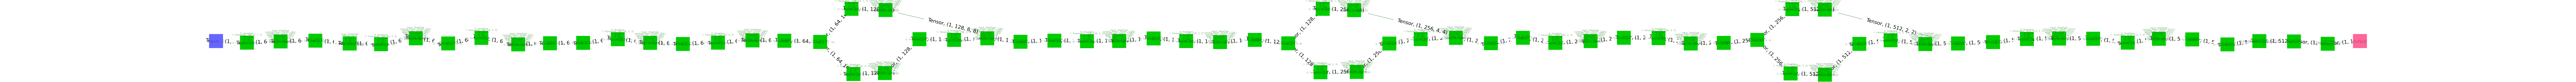

In [29]:
Image('resnet18.png')

By passing `return_graph=True` parameter to `compile_graph` you can obtain graph object. It has `_all_functions` attribute that stores all the functions in order of their execution. 

If `time_chronological=True` the order of functions will the same as in the definition of network. If `time_chronological=False` Ivy's graph tracer will try to find optimal order for better inference speed without affecting the accuracy.

In [31]:
comp_network, graph = compile_graph(net, x0, return_graph=True, time_chronological=True)
print([fn.__name__ for fn in graph._all_functions])

/usr/local/lib/python3.8/dist-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


['conv2d', 'batch_norm', 'relu', 'max_pool2d', 'conv2d', 'batch_norm', 'relu', 'conv2d', 'batch_norm', '__iadd__', 'relu', 'conv2d', 'batch_norm', 'relu', 'conv2d', 'batch_norm', '__iadd__', 'relu', 'conv2d', 'conv2d', 'batch_norm', 'batch_norm', 'relu', 'conv2d', 'batch_norm', '__iadd__', 'relu', 'conv2d', 'batch_norm', 'relu', 'conv2d', 'batch_norm', '__iadd__', 'relu', 'conv2d', 'conv2d', 'batch_norm', 'batch_norm', 'relu', 'conv2d', 'batch_norm', '__iadd__', 'relu', 'conv2d', 'batch_norm', 'relu', 'conv2d', 'batch_norm', '__iadd__', 'relu', 'conv2d', 'conv2d', 'batch_norm', 'batch_norm', 'relu', 'conv2d', 'batch_norm', '__iadd__', 'relu', 'conv2d', 'batch_norm', 'relu', 'conv2d', 'batch_norm', '__iadd__', 'relu', 'adaptive_avg_pool2d', 'flatten', 'linear']
